In [1]:
import os    
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import keras
from keras.datasets import cifar10
from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model
from keras.layers import concatenate,Dropout,Flatten

from keras import optimizers,regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import he_normal
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf

num_classes        = 10
batch_size         = 64         # 64 or 32 or other
epochs             = 10
iterations         = 782       
DROPOUT=0.5 # keep 50%
CONCAT_AXIS=3
weight_decay=1e-4
DATA_FORMAT='channels_last' # Theano:'channels_first' Tensorflow:'channels_last'
log_filepath  = './alexnet'

In [2]:
def alexnet(img_input,classes=10):
    #Conv1-------------------
    x = Conv2D(96,(11,11),strides=(4,4),padding='same',activation='relu',kernel_initializer='uniform')(img_input)# valid
    #LRN1
    x = tf.nn.lrn(x,depth_radius=4, bias = 2, alpha = 0.001/9, beta = 0.75)
    #MaxPooling1
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    
    #Conv2--------------------
    x = Conv2D(256,(5,5),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform')(x)
    #LRN2
    x = tf.nn.lrn(x,depth_radius=4, bias = 2, alpha = 0.001/9, beta = 0.75)
    #MaxPooling2
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    
    #Conv3--------------------
    x = Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform')(x) 
    
    #Conv4--------------------
    x = Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform')(x) 
    
    #Conv5--------------------
    x = Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform')(x)
    #MaxPooling3
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    
    #FC-----------------------
    x = Flatten()(x)
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(classes, activation='softmax')(x)
    return out

In [3]:
img_input=Input(shape=(32,32,3))
output = alexnet(img_input)
model=Model(img_input,output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 96)          34944     
_________________________________________________________________
tf.nn.local_response_normali (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
tf.nn.local_response_normali (None, 4, 4, 256)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0     

In [4]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# data preprocessing 
x_train[:,:,:,0] = (x_train[:,:,:,0]-123.680)
x_train[:,:,:,1] = (x_train[:,:,:,1]-116.779)
x_train[:,:,:,2] = (x_train[:,:,:,2]-103.939)
x_test[:,:,:,0] = (x_test[:,:,:,0]-123.680)
x_test[:,:,:,1] = (x_test[:,:,:,1]-116.779)
x_test[:,:,:,2] = (x_test[:,:,:,2]-103.939)

y_train = np_utils.to_categorical(y_train, num_classes)
y_test  = np_utils.to_categorical(y_test, num_classes)

In [5]:
def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 200:
        return 0.001
    return 0.0001

In [6]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set callback
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

C:\Users\prwro\.conda\envs\machineLearning\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
history = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))

Epoch 1/10
782/782 [==============================] - 24s 24ms/step - loss: 2.0206 - accuracy: 0.2504 - val_loss: 1.6800 - val_accuracy: 0.3745
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 1.6069 - accuracy: 0.4040 - val_loss: 1.4698 - val_accuracy: 0.4672
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 1.4900 - accuracy: 0.4554 - val_loss: 1.3941 - val_accuracy: 0.5025
Epoch 4/10
782/782 [==============================] - 18s 23ms/step - loss: 1.4256 - accuracy: 0.4835 - val_loss: 1.3056 - val_accuracy: 0.5312
Epoch 5/10
782/782 [==============================] - 19s 24ms/step - loss: 1.3771 - accuracy: 0.5042 - val_loss: 1.3139 - val_accuracy: 0.5314
Epoch 6/10
782/782 [==============================] - 26s 33ms/step - loss: 1.3371 - accuracy: 0.5197 - val_loss: 1.2400 - val_accuracy: 0.5600
Epoch 7/10
782/782 [==============================] - 21s 27ms/step - loss: 1.3140 - accuracy: 0.5302 - val_loss: 1.2674 - val_accuracy:

In [8]:
# 搞定，画图，显示训练集和验证集的acc和loss曲线
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


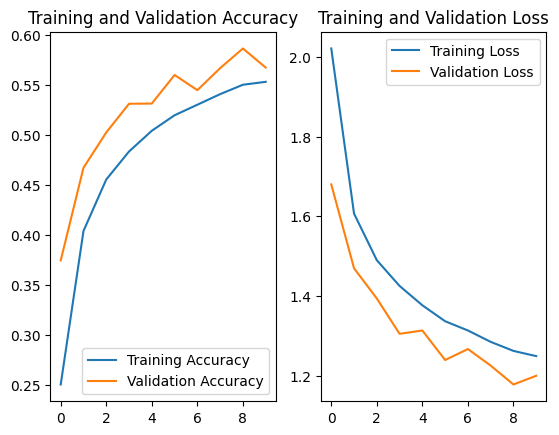

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()